<a href="https://colab.research.google.com/github/miraculusik/tensorflow-deep-learning-practices/blob/main/transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Questions

- Q1 : Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

- Q2 : Name 3 different image classification models on TensorFlow Hub that we haven't used.


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-08-07 16:37:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   286MB/s    in 0.6s    

2021-08-07 16:37:03 (286 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os

for root, dirname, filename in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{root}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_crea

In [ ]:
#get class names
import pathlib
import numpy as np

data_dir = pathlib.Path("10_food_classes_10_percent/train")

class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_random_image(data_dir, class_names):
  """
  Example of Usage:
  visualize_random_image("data/train/", class_names)
  """
  random_class = random.choice(class_names)
  target_folder = data_dir + random_class
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(random_class + "\nimg shape:"+str(img.shape))
  plt.axis(False)
  plt.tight_layout()

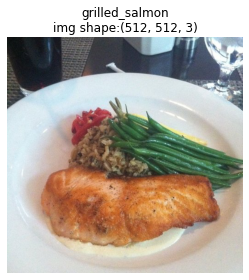

In [ ]:
visualize_random_image("10_food_classes_10_percent/train/", class_names)

In [ ]:
# data generate
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               batch_size=32
                                               )
test_data = test_datagen.flow_from_directory(test_dir,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               batch_size=32
                                             )

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Q1

Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

In [ ]:
mobilnet_v2_130_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

def create_model(model_url, class_num, input_shape=(224, 224,3)):
  """
  Return:
  Created and compiled model
  """
  feature_extractor_layer = hub.KerasLayer(model_url,
                                            trainable=False,
                                            input_shape=input_shape,
                                            name="feature_extractor",
                                          )
  model = Sequential([
    feature_extractor_layer,
    Dense(class_num, activation="softmax", name="output_layer")
  ])

  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
  return model

In [ ]:
mobilnet_v2_130_model = create_model(mobilnet_v2_130_url, train_data.num_classes)

In [ ]:
mobilnet_v2_130_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (KerasLaye (None, 1001)              5432713   
_________________________________________________________________
output_layer (Dense)         (None, 10)                10020     
Total params: 5,442,733
Trainable params: 10,020
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
import datetime

def tensorboard_callback(experiment_name):

  log_dir = "Tensorflow_hub" + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y.%m.%d-%H:%M:%S")

  tensorboard = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

  print(f"Saving Tensorflow log files to: {log_dir}")

  return tensorboard

## Fit : mobilnet_v2_130_model

In [ ]:
mobilnet_v2_130_model.fit(train_data,
                          epochs=5,
                          validation_data = test_data,
                          callbacks =[tensorboard_callback(experiment_name="mobilnet_v2_130")])

Saving Tensorflow log files to: Tensorflow_hub/mobilnet_v2_130/2021.08.07-16:37:10
Epoch 1/5
24/24 [==============================] - 21s 691ms/step - loss: 2.0626 - accuracy: 0.3493 - val_loss: 1.0895 - val_accuracy: 0.6420
Epoch 2/5
24/24 [==============================] - 15s 638ms/step - loss: 0.8356 - accuracy: 0.7373 - val_loss: 0.7225 - val_accuracy: 0.7676
Epoch 3/5
24/24 [==============================] - 15s 649ms/step - loss: 0.5650 - accuracy: 0.8160 - val_loss: 0.6404 - val_accuracy: 0.7928
Epoch 4/5
24/24 [==============================] - 14s 605ms/step - loss: 0.4380 - accuracy: 0.8747 - val_loss: 0.6047 - val_accuracy: 0.7964
Epoch 5/5
24/24 [==============================] - 14s 605ms/step - loss: 0.3483 - accuracy: 0.9120 - val_loss: 0.5780 - val_accuracy: 0.8064


In [ ]:
def plot_model_curves(history):
  #Loss
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  #Accuracy
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  #get epoch number 
  x_range = np.arange(1,len(loss)+1)
  
  #Plot figures 
  plt.figure(figsize=(12,6))
  # figure 1 - (loss & val_loss)
  plt.subplot(121)
  plt.plot(x_range, loss, label="loss")
  plt.plot(x_range, val_loss, label="val_loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.grid(color='gray', linestyle='-', linewidth=0.5)
  # figure 2 - (accuracy & val_accuracy)
  plt.subplot(122)
  plt.plot(x_range, accuracy, label="accuracy")
  plt.plot(x_range, val_accuracy, label="val_accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuraacy")
  plt.legend()
  plt.grid(color='gray', linestyle='-', linewidth=0.5)

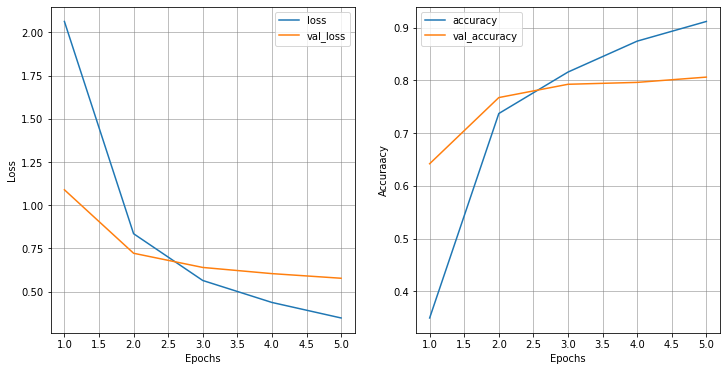

In [ ]:
plot_model_curves(mobilnet_v2_130_model.history)

# Q2

 Name 3 different image classification models on TensorFlow Hub that we haven't used.

## Model-1 (inception_v3)


[model_link](https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4)

In [ ]:
inception_v3_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

In [ ]:
inception_v3_model = create_model(model_url=inception_v3_url,
                                  class_num = train_data.num_classes)

In [ ]:
inception_v3_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (KerasLaye (None, 2048)              21802784  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
inception_v3_model.fit(train_data,
                       epochs = 5,
                       validation_data = test_data,
                       callbacks=[tensorboard_callback(experiment_name="inception_v3")])

Saving Tensorflow log files to: Tensorflow_hub/inception_v3/2021.08.07-16:39:11
Epoch 1/5
24/24 [==============================] - 24s 792ms/step - loss: 1.7848 - accuracy: 0.4347 - val_loss: 1.0748 - val_accuracy: 0.6288
Epoch 2/5
24/24 [==============================] - 15s 642ms/step - loss: 0.9301 - accuracy: 0.7013 - val_loss: 0.8315 - val_accuracy: 0.7248
Epoch 3/5
24/24 [==============================] - 16s 673ms/step - loss: 0.7177 - accuracy: 0.7787 - val_loss: 0.7752 - val_accuracy: 0.7380
Epoch 4/5
24/24 [==============================] - 15s 650ms/step - loss: 0.5903 - accuracy: 0.8107 - val_loss: 0.6814 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 15s 633ms/step - loss: 0.4788 - accuracy: 0.8587 - val_loss: 0.6889 - val_accuracy: 0.7768


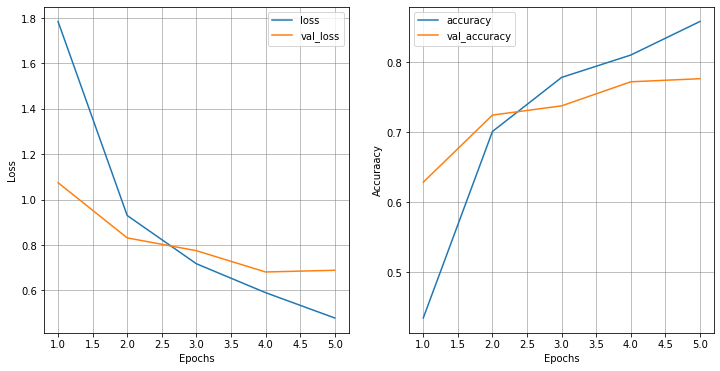

In [ ]:
plot_model_curves(inception_v3_model.history)

## Model 2 (inception_resnet_v2)

[model_link](https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5)

In [ ]:
inception_resnet_v2_url = "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/5"

In [ ]:
inception_resnet_v2_model = create_model(model_url=inception_resnet_v2_url,
                                         class_num = train_data.num_classes)

In [ ]:
inception_resnet_v2_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (KerasLaye (None, 1536)              54336736  
_________________________________________________________________
output_layer (Dense)         (None, 10)                15370     
Total params: 54,352,106
Trainable params: 15,370
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
inception_resnet_v2_model.fit(train_data,
                              epochs=5,
                              validation_data = test_data,
                              callbacks=[tensorboard_callback(experiment_name="inception_resnet_v2")])

Saving Tensorflow log files to: Tensorflow_hub/inception_resnet_v2/2021.08.07-16:56:03
Epoch 1/5
24/24 [==============================] - 37s 1s/step - loss: 1.8011 - accuracy: 0.4120 - val_loss: 0.9989 - val_accuracy: 0.6824
Epoch 2/5
24/24 [==============================] - 20s 854ms/step - loss: 0.9636 - accuracy: 0.6920 - val_loss: 0.7798 - val_accuracy: 0.7288
Epoch 3/5
24/24 [==============================] - 20s 848ms/step - loss: 0.7445 - accuracy: 0.7840 - val_loss: 0.6841 - val_accuracy: 0.7796
Epoch 4/5
24/24 [==============================] - 19s 817ms/step - loss: 0.6696 - accuracy: 0.7787 - val_loss: 0.6935 - val_accuracy: 0.7696
Epoch 5/5
24/24 [==============================] - 19s 825ms/step - loss: 0.5729 - accuracy: 0.8347 - val_loss: 0.6200 - val_accuracy: 0.7936


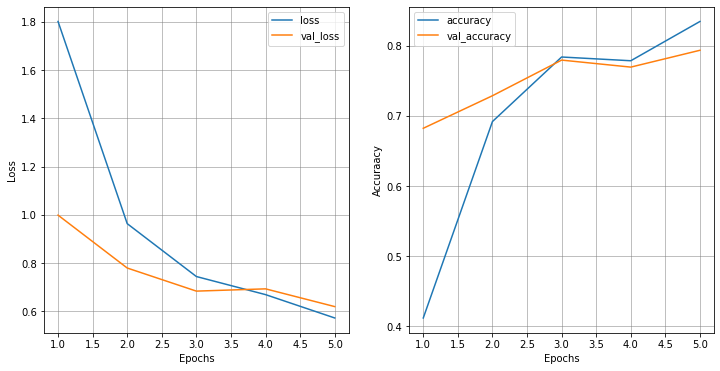

In [ ]:
plot_model_curves(inception_resnet_v2_model.history)

## Model 3 (resnet_50)

[model link](https://tfhub.dev/tensorflow/resnet_50/feature_vector/1)

In [ ]:
resnet_50_url = "https://tfhub.dev/tensorflow/resnet_50/feature_vector/1"

In [ ]:
resnet_50_model = create_model(resnet_50_url,
                               class_num = train_data.num_classes)

In [ ]:
resnet_50_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extractor (KerasLaye (None, 2048)              23561152  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,581,642
Trainable params: 20,490
Non-trainable params: 23,561,152
_________________________________________________________________


In [ ]:
resnet_50_model.fit(train_data,
                    epochs=5,
                    validation_data = test_data,
                    callbacks=[tensorboard_callback(experiment_name="resnet_50")])

Saving Tensorflow log files to: Tensorflow_hub/resnet_50/2021.08.07-17:03:22
Epoch 1/5
24/24 [==============================] - 26s 895ms/step - loss: 1.8771 - accuracy: 0.3880 - val_loss: 1.0880 - val_accuracy: 0.6660
Epoch 2/5
24/24 [==============================] - 16s 704ms/step - loss: 0.8465 - accuracy: 0.7293 - val_loss: 0.7666 - val_accuracy: 0.7668
Epoch 3/5
24/24 [==============================] - 16s 699ms/step - loss: 0.5721 - accuracy: 0.8240 - val_loss: 0.6542 - val_accuracy: 0.7884
Epoch 4/5
24/24 [==============================] - 17s 710ms/step - loss: 0.4186 - accuracy: 0.8813 - val_loss: 0.5943 - val_accuracy: 0.8100
Epoch 5/5
24/24 [==============================] - 17s 742ms/step - loss: 0.3327 - accuracy: 0.9307 - val_loss: 0.5627 - val_accuracy: 0.8268


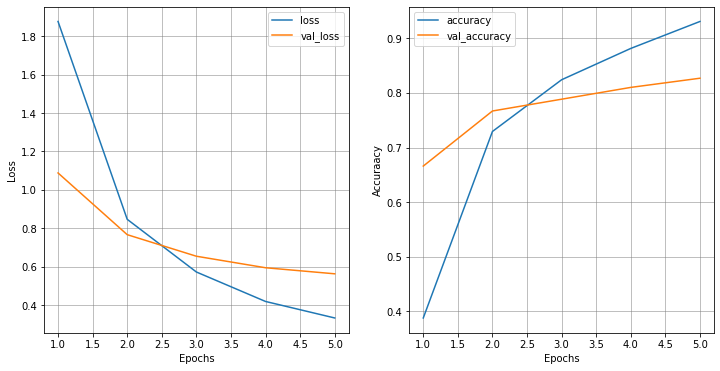

In [ ]:
plot_model_curves(resnet_50_model.history)